## General

This notebook uses parametric modelling of the binary black hole merger population from the [Gravitational-Wave Transient Catalog 4.0 (GTWC-4.0)]([https://doi.org/10.48550/arXiv.2508.18082]). It utilises the gravitational-wave population inference code [GWPopulation]([https://doi.org/10.21105/joss.07753]) and accompanies the paper [Stegmann et al. (2025)]([https://doi.org/10.48550/arXiv.2512.15873]), which investigates the spin-orbit tilt angle distribution and its astrophysical implications about formation channels. This script builds upon the [GWPopulation example file]([https://example.com](https://colmtalbot.github.io/gwpopulation/examples/GWTC3.html)), which contains additional documentation. It is highly recommended to check it out first.

## Imports

In [1]:
import bilby as bb
import gwpopulation as gwpop
import jax
import matplotlib.pyplot as plt
import pandas as pd
from bilby.core.prior import PriorDict, Uniform, TruncatedNormal
from bilby.hyper.model import Model
from gwpopulation.experimental.jax import JittedLikelihood

gwpop.set_backend("jax")

xp = gwpop.utils.xp

%matplotlib inline

In [2]:
# 1) install
%pip -q install gdown

# 2) download the whole folder into a local directory (e.g. ./gdrive_folder)
!gdown --folder "https://drive.google.com/drive/folders/18cJxs64WUN72aHBGJlgeGcZjGB9WRV0X?usp=sharing" -O .

# 3) inspect
!ls -lah .

Note: you may need to restart the kernel to use updated packages.
Retrieving folder contents
Processing file 1RNH0l89utcXjIoe0f9fs480_3twG7Y2j Antonini2018.csv
Processing file 1PxNJHzraqALST7xM6rHJPFjYlby87M9r figure_7_spin_tilt_bspline.npz
Processing file 19OISvD4x7ipM1nY_8SW_jCqpBVoFrvmf gwtc4_injections_dict.pkl
Processing file 1bzwcVACaVUePVzRqe9GA_w8S1zmurTAk gwtc4_posteriors.pkl
Processing file 1w2puFvsBvy1Yicc52TZeu0ubPL5BzpxU High_costheta_weighted.txt
Processing file 12a5WHXgpfL5K3CyYgJ7cQmw51MHn6Qk6 Standard_costheta_weighted.txt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1RNH0l89utcXjIoe0f9fs480_3twG7Y2j
To: /Users/stegmaja/Documents/Black-hole-spin-orbit-tilts/Antonini2018.csv
100%|██████████████████████████████████████████| 640/640 [00:00<00:00, 1.72MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1PxNJHzraqALST7xM6rHJPFjYlby87M9r
From (redi

## Load posteriors

In [3]:
posteriors = pd.read_pickle("gwtc4_posteriors.pkl")

## Load injections

In [4]:
injections = pd.read_pickle("gwtc4_injections_dict.pkl")

## Run the sampler

In [ ]:
# We are considering the default Gaussian_Isotropic_Cut spin model from Stegmann et al. (2025)
label = 'Gaussian_Isotropic_Cut'

################## IMPORTANT SETTINGS ##################

# Control maximum uncertainty in selection function estimation
# For production runs (as used in Stegmann et al. (2025)), I recommend setting maximum_uncertainty = 1, naccept = 5, nlive = 1000 (which should take several hours)
# For quick tests, you can set maximum_uncertainty = xp.inf, naccept = 5, nlive = 100 (which should take several minutes)
maximum_uncertainty = xp.inf
naccept = 5
nlive = 100

########################################################

# Define custom spin model
def spin_model(dataset, mu_1, sigma_1, mu_tilt_1, sigma_tilt_1, 
               mu_2, sigma_2, mu_3, sigma_3,
               weight_a, m_cut):
    
    # Unpack variables from dataset
    a_1 = dataset["a_1"]
    a_2 = dataset["a_2"]
    cos_tilt_1 = dataset["cos_tilt_1"]
    cos_tilt_2 = dataset["cos_tilt_2"]
    m_1 = dataset["mass_1"]

    # Free Gaussian component
    comp1 = gwpop.utils.truncnorm(a_1, mu_1, sigma_1, 1, 0) * \
            gwpop.utils.truncnorm(a_2, mu_1, sigma_1, 1, 0) * \
            gwpop.utils.truncnorm(cos_tilt_1, mu_tilt_1, sigma_tilt_1, 1, -1) * \
            gwpop.utils.truncnorm(cos_tilt_2, mu_tilt_1, sigma_tilt_1, 1, -1)

    # Isotropic component
    comp2 = gwpop.utils.truncnorm(a_1, mu_2, sigma_2, 1, 0) * \
            gwpop.utils.truncnorm(a_2, mu_2, sigma_2, 1, 0) * \
            0.5 * 0.5 
    
    # High-mass isotropic component
    comp3 = gwpop.utils.truncnorm(a_1, mu_3, sigma_3, 1, 0) * \
            gwpop.utils.truncnorm(a_2, mu_3, sigma_3, 1, 0) * \
            0.5 * 0.5 
    
    # Mass-dependent transition function
    zeta = 1/(1 + xp.exp(-m_1+m_cut))
    
    # Combine components with mass-dependent transition
    return (1 - zeta) * (weight_a * comp1 + (1 - weight_a) * comp2) + zeta * comp3

# Define the full population model, combining mass, spin, and redshift models
model = Model(
    model_functions=[
        gwpop.models.mass.two_component_primary_mass_ratio,
        spin_model,
        gwpop.models.redshift.PowerLawRedshift(cosmo_model="Planck15"),
    ],
    cache=False,
)

vt = gwpop.vt.ResamplingVT(model=model, data=injections, n_events=len(posteriors))

likelihood = gwpop.hyperpe.HyperparameterLikelihood(
    posteriors=posteriors,
    hyper_prior=model,
    selection_function=vt,
    maximum_uncertainty=maximum_uncertainty,
)

# Define priors for hyperparameters
priors = PriorDict()

# mass
priors["alpha"] = Uniform(minimum=-2, maximum=4, latex_label="$\\alpha$")
priors["beta"] = Uniform(minimum=-4, maximum=12, latex_label="$\\beta$")
priors["mmin"] = Uniform(minimum=2, maximum=2.5, latex_label="$m_{\\min}$")
priors["mmax"] = Uniform(minimum=80, maximum=100, latex_label="$m_{\\max}$")
priors["lam"] = Uniform(minimum=0, maximum=1, latex_label="$\\lambda_{m}$")
priors["mpp"] = Uniform(minimum=10, maximum=50, latex_label="$\\mu_{m}$")
priors["sigpp"] = Uniform(minimum=1, maximum=10, latex_label="$\\sigma_{m}$")
priors["gaussian_mass_maximum"] = 100
# spin
priors["mu_1"] = Uniform(minimum=0, maximum=1, latex_label="$\\mu_1$")
priors["sigma_1"] = Uniform(minimum=0.1, maximum=1, latex_label="$\\sigma_1$")
priors["mu_tilt_1"] = Uniform(minimum=-1, maximum=1, latex_label="$\\mu_{t,1}$")
priors["sigma_tilt_1"] = TruncatedNormal(minimum=0.1, maximum=4, sigma=1/2, mu=0, latex_label="$\\sigma_{t,1}$")
priors["mu_2"] = Uniform(minimum=0, maximum=1, latex_label="$\\mu_2$")
priors["sigma_2"] = Uniform(minimum=0.1, maximum=1, latex_label="$\\sigma_2$")
priors["weight_a"] = Uniform(minimum=0, maximum=1, latex_label="$w_a$")
priors["mu_3"] = Uniform(minimum=0, maximum=1, latex_label="$\\mu_3$")
priors["sigma_3"] = Uniform(minimum=0.1, maximum=1, latex_label="$\\sigma_3$")
priors["m_cut"] = Uniform(minimum=10, maximum=100, latex_label="$m_{\\rm cut}$")

# redshift
priors["lamb"] = Uniform(minimum=-1, maximum=10, latex_label="$\\lambda_{z}$")

# Test JittedLikelihood
parameters = priors.sample()
likelihood.parameters.update(parameters)
likelihood.log_likelihood_ratio()
print(likelihood.log_likelihood_ratio())
jit_likelihood = JittedLikelihood(likelihood)
jit_likelihood.parameters.update(parameters)
print(jit_likelihood.log_likelihood_ratio())
print(jit_likelihood.log_likelihood_ratio())

# Run sampler
result = bb.run_sampler(
    likelihood=jit_likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=nlive,
    label=label,
    sample="acceptance-walk",
    naccept=naccept,
    save="hdf5",
    outdir="out_" + label,
)

-833.1751443937906


10:18 bilby INFO    : Running for label 'Gaussian_Isotropic_Cut', output will be saved to 'out_Gaussian_Isotropic_Cut'


-833.1751443937906
-833.1751443937906


10:18 bilby INFO    : Analysis priors:
10:18 bilby INFO    : alpha=Uniform(minimum=-2, maximum=4, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
10:18 bilby INFO    : beta=Uniform(minimum=-4, maximum=12, name=None, latex_label='$\\beta$', unit=None, boundary=None)
10:18 bilby INFO    : mmin=Uniform(minimum=2, maximum=2.5, name=None, latex_label='$m_{\\min}$', unit=None, boundary=None)
10:18 bilby INFO    : mmax=Uniform(minimum=80, maximum=100, name=None, latex_label='$m_{\\max}$', unit=None, boundary=None)
10:18 bilby INFO    : lam=Uniform(minimum=0, maximum=1, name=None, latex_label='$\\lambda_{m}$', unit=None, boundary=None)
10:18 bilby INFO    : mpp=Uniform(minimum=10, maximum=50, name=None, latex_label='$\\mu_{m}$', unit=None, boundary=None)
10:18 bilby INFO    : sigpp=Uniform(minimum=1, maximum=10, name=None, latex_label='$\\sigma_{m}$', unit=None, boundary=None)
10:18 bilby INFO    : mu_1=Uniform(minimum=0, maximum=1, name=None, latex_label='$\\mu_1$', unit=None, b

3046it [39:58,  1.27it/s, bound:88 nc: 13 ncall:5.7e+04 eff:5.4% logz-ratio=-727.44+/-0.45 dlogz:0.1>0.1]  

10:59 bilby INFO    : Written checkpoint file out_Gaussian_Isotropic_Cut/Gaussian_Isotropic_Cut_resume.pickle
10:59 bilby INFO    : Written checkpoint file out_Gaussian_Isotropic_Cut/Gaussian_Isotropic_Cut_resume.pickle


3046it [40:05,  1.27it/s, bound:88 nc:  1 ncall:5.7e+04 eff:5.6% logz-ratio=-727.41+/-0.47 dlogz:0.000996>0.1]

10:59 bilby INFO    : Rejection sampling nested samples to obtain 768 posterior samples
10:59 bilby INFO    : Sampling time: 0:40:05.321458
10:59 bilby INFO    : Summary of results:
nsamples: 768
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.527
ln_bayes_factor: -727.405 +/-  0.527



## Corner plot for the spin properties

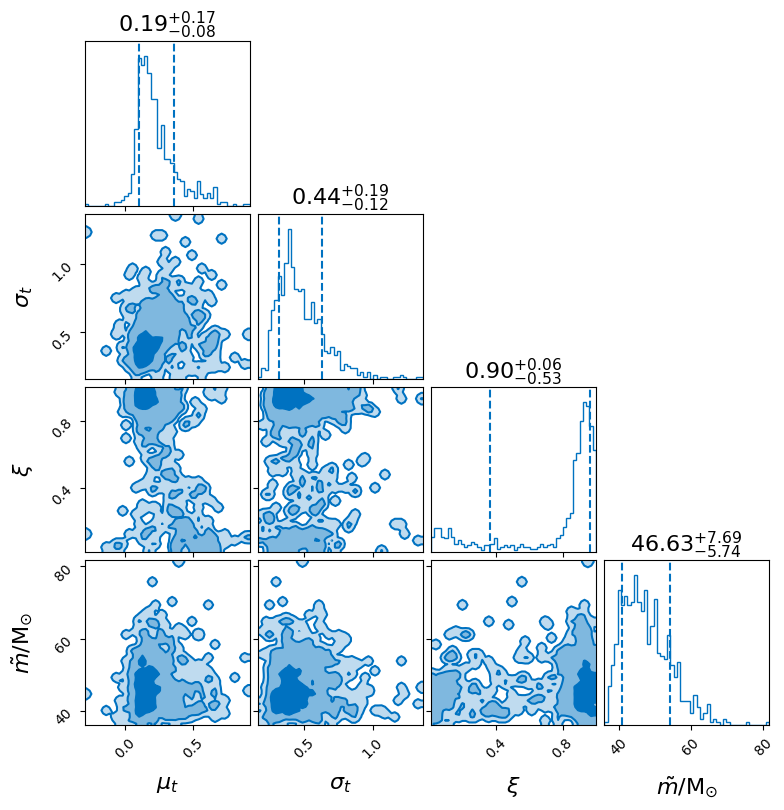

In [6]:
fig,axs = plt.subplots(4,4,figsize=(8,8))

_ = result.plot_corner(
    save=False, fig=fig,
    parameters=['mu_tilt_1','sigma_tilt_1','weight_a','m_cut'],
    labels=[r'$\\mu_t$',r'$\\sigma_t$',r'$\\xi$',r'$\\tilde{m}/\rm M_{\odot}$'],
    density=True,
)

plt.savefig(f"corner.png", dpi=300, bbox_inches='tight')

## PPD plot

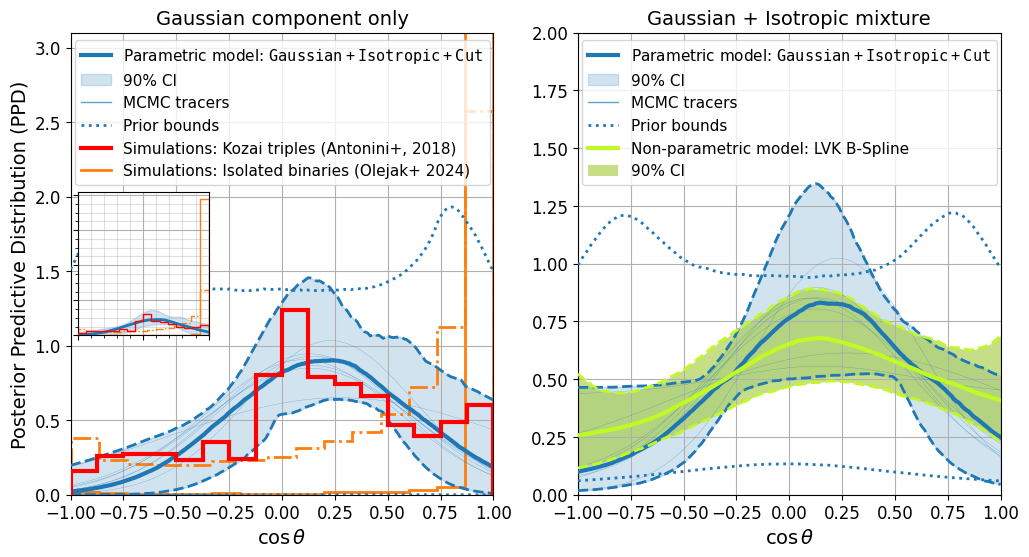

In [7]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

quantiles = [5, 95]
quantile_label = '90% CI'
show_prior = True

fig,axs = plt.subplots(1,2, figsize=(12,6), sharey=False)

# Create inset
ax_inset = inset_axes(axs[0], width="31%", height="31%", loc='center left')
ax_inset.set_xlim(-1, 1)
ax_inset.minorticks_on()

# grid for both major and minor
ax_inset.grid(True, which='major')
ax_inset.grid(True, which='minor', alpha=0.4)  # optional: lighter minor grid

# keep ticks, hide numbers
ax_inset.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

# Plot Gaussian_Isotropic_Cut
color = 'C0'
label = 'Gaussian_Isotropic_Cut'
plot_label = r'$\tt{Gaussian + Isotropic + Cut}$'
mu_tilt_1   = result.posterior['mu_tilt_1'].values
sigma_tilt_1 = result.posterior['sigma_tilt_1'].values
weight_a    = result.posterior['weight_a'].values

for i,ax in enumerate(axs):
    xx = np.linspace(-1, 1, 200)
    yy = np.array([
        gwpop.utils.truncnorm(xx, mu, sigma, low=-1, high=1) * w + (1 - w) * 0.5 if i==1 else gwpop.utils.truncnorm(xx, mu, sigma, low=-1, high=1)
        for mu, sigma, w in zip(mu_tilt_1, sigma_tilt_1, weight_a)
    ])
    median = np.median(yy, axis=0)
    low, high = np.percentile(yy, quantiles, axis=0)   # 90% band
    ax.plot(xx, median, label='Parametric model: '+plot_label, linestyle='solid', lw=3, color=color, zorder=10)
    ax.fill_between(xx, low, high, alpha=0.2, color=color, label=quantile_label)
    for yy in [low, high]: ax.plot(xx, yy, lw=2, color=color, zorder=10, linestyle='dashed')

    if i==0:
        ax_inset.plot(xx, median, linestyle='solid', lw=2, color=color, zorder=10)
        ax_inset.fill_between(xx, low, high, alpha=0.2, color=color)

    # population tracers
    thin = 100
    yy_tracers = np.array([
        gwpop.utils.truncnorm(xx, mu, sigma, low=-1, high=1) * w + (1 - w) * 0.5 if i==1 else gwpop.utils.truncnorm(xx, mu, sigma, low=-1, high=1)
        for mu, sigma, w in zip(mu_tilt_1[::thin], sigma_tilt_1[::thin], weight_a[::thin])
    ])
    for i,yy in enumerate(yy_tracers):
        if i == 0:
            ax.plot(xx, yy*-1, lw=1, color=color, alpha=.7, zorder=5, label='MCMC tracers')
        else:
            ax.plot(xx, yy, lw=.2, color=color, alpha=.7, zorder=5)

    ax.grid()
    ax.set_xlabel(r'$\cos\theta$',fontsize=14)
    ax.set_xlim(-1, 1)
    ax.set_ylim(0)

# Prior
if show_prior:
    mu_tilt_1_prior   = np.random.uniform(-1, 1, size=100000)
    sigma_tilt_1_prior = scipy.stats.truncnorm.rvs(
        (0.1 - 0) / (1/2), (4 - 0) / (1/2), loc=0, scale=1/2, size=100000
    )
    weight_a_prior    = np.random.uniform(0, 1, size=100000)
    for i,ax in enumerate(axs):
        yy_prior = np.array([
            gwpop.utils.truncnorm(xx, mu, sigma, low=-1, high=1) * w + (1 - w) * 0.5 if i==1 else gwpop.utils.truncnorm(xx, mu, sigma, low=-1, high=1)
            for mu, sigma, w in zip(mu_tilt_1_prior, sigma_tilt_1_prior, weight_a_prior)
        ])
        low_prior, high_prior = np.percentile(yy_prior, quantiles, axis=0)   # 90% band
        for yy in [low_prior, high_prior]: 
            label = 'Prior bounds' if yy is low_prior else None
            ax.plot(xx, yy, lw=2, color=color, zorder=10, linestyle='dotted',label=label)
        
# Non-parametric
ax = axs[1]
bspline_data = np.load('figure_7_spin_tilt_bspline.npz')
x = np.squeeze(bspline_data['x'])
y = bspline_data['y']
y_med = np.median(y, axis=0)
y_lo  = np.percentile(y, quantiles[0], axis=0)   # lower bound
y_hi  = np.percentile(y, quantiles[1], axis=0)  # upper bound
ax.plot(x, y_med,label='Non-parametric model: LVK B-Spline',color="#C1F925", lw=3, zorder=20)
ax.fill_between(x, y_lo, y_hi,alpha=0.6, linewidth=0, color='#A1C935',label=quantile_label)
for yy in [y_lo, y_hi]: ax.plot(x, yy, lw=2, color="#C1F925", zorder=20, linestyle='dashed')

# Antonini
ax = axs[0]
df = pd.read_csv('Antonini2018.csv')
x_Antonini = np.array(df['x'])
y_Antonini = np.array(df[' y'])
y_Antonini = y_Antonini[np.argsort(x_Antonini)]
x_Antonini = np.linspace(-1,1,len(y_Antonini),endpoint=False)
w = 2/len(y_Antonini)
edges = np.r_[x_Antonini, x_Antonini[-1] + w]  # N+1 edges for N heights
ax.stairs(y_Antonini, edges, linewidth=3, color='red', label='Simulations: Kozai triples (Antonini+, 2018)', zorder=10)    # no fill, clean step outline
ax_inset.stairs(y_Antonini, edges, linewidth=1, color='red', label='Simulations: Kozai triples (Antonini+, 2018)', zorder=10)    # no fill, clean step outline

axs[0].set_ylabel('Posterior Predictive Distribution (PPD)',fontsize=14)
axs[0].set_title(f'Gaussian component only',fontsize=14)
axs[1].set_title(f'Gaussian + Isotropic mixture',fontsize=14)

# Binary models
ax = axs[0]
bins = np.linspace(-1, 1, 16)
cos,w = np.loadtxt('Standard_costheta_weighted.txt',unpack=True)
ax.hist(cos,weights=w/np.sum(w)*np.sum(y_Antonini),bins=bins,histtype='step',color='C1',lw=2,alpha=1)
ax_inset.hist(cos,weights=w/np.sum(w)*np.sum(y_Antonini),bins=bins,histtype='step',color='C1',lw=1,alpha=1)
cos,w = np.loadtxt('High_costheta_weighted.txt',unpack=True)
ax.hist(cos,weights=w/np.sum(w)*np.sum(y_Antonini),bins=bins,histtype='step',color='C1',linestyle='dashdot',lw=2,alpha=1)
ax_inset.hist(cos,weights=w/np.sum(w)*np.sum(y_Antonini),bins=bins,histtype='step',color='C1',linestyle='dashdot',lw=1,alpha=1)

# dummy plot for legend
axs[0].plot([],[],color='C1',lw=2,label='Simulations: Isolated binaries (Olejak+ 2024)')

axs[0].legend(loc='upper center',fontsize=11)
axs[1].legend(loc='upper center',fontsize=11)

axs[0].set_ylim(0, 3.1)
axs[1].set_ylim(0, 2)

# tick font size
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.savefig(f"PPD.png", dpi=300, bbox_inches='tight')